# Visualizing correlates of 'SNPs in gene'

In [1]:
library(dplyr, warn=FALSE)
library(readr)
library(tidyr)
library(ggplot2)

In [2]:
combined_df = readr::read_tsv('data/combined.tsv.gz')
head(combined_df, 2)

Source: local data frame [2 x 14]

  entrez_gene_id symbol    node                                    metaedge
1              1   A1BG gene::1 gene < overexpression downregulation < gene
2              1   A1BG gene::1   gene - participation - molecular function
Variables not shown: degree (int), snps_hh550 (dbl), snps_ho1 (dbl),
  snps_affy500 (dbl), snps_exac (dbl), degree_log (dbl), snps_hh550_log (dbl),
  snps_ho1_log (dbl), snps_affy500_log (dbl), snps_exac_log (dbl)

In [3]:
metaedge_df = readr::read_tsv('download/network-summary.tsv')
metaedge_df = metaedge_df %>%
  dplyr::filter(edges >= 1000)

In [4]:
metaedge_subset = c(
  'gene - function - disease',
  'gene - participation - biological process',
  'gene - participation - molecular function',
  'gene - participation - cellular component',
  'gene - participation - pathway',
  'gene - expression - anatomy',
  'gene - interaction - gene',
  'gene - regulation - perturbation'
)

In [5]:
gathered_df = combined_df %>%
  tidyr::gather(platform, snps_log, snps_hh550_log, snps_ho1_log, snps_affy500_log, snps_exac_log) %>%
  na.omit() %>%
  dplyr::inner_join(metaedge_df %>% dplyr::select(metaedge, abbreviation))

Joining by: "metaedge"


In [6]:
percentile_df = gathered_df %>%
  dplyr::group_by(platform) %>%
  dplyr::summarize(
    percentile_98 = quantile(snps_log, 0.98)
  )
percentile_df

Source: local data frame [4 x 2]

          platform percentile_98
1   snps_hh550_log      2.103804
2     snps_ho1_log      2.281033
3 snps_affy500_log      2.025306
4    snps_exac_log      1.361728

In [7]:
gathered_df = gathered_df %>%
  dplyr::inner_join(percentile_df) %>%
  dplyr::filter(snps_log <= percentile_98)

Joining by: "platform"


## Visualization helpers

In [8]:
platforms = c(
  'snps_affy500_log'='Affymetrix 500K Set',
  'snps_hh550_log'='Illumina HumanHap550',
  'snps_ho1_log'='Illumina HumanOmni1',
  'snps_exac_log'='ExAC'
)

facet_labeller = function(variable, value) {
  if (variable != 'platform') {return(as.character(value))}
  return(platforms[value])
}

In [9]:
log10p = function(x) {log10(1 + x)}
snp_labels = round(10 ** seq(0, 3, 0.32) - 1)

In [10]:
gg_base = function(gg) {
    gg = gg + 
      ggplot2::theme_bw() + 
      ggplot2::theme(strip.background=ggplot2::element_rect(fill='#FEF2E2')) +
      ggplot2::theme(plot.margin = grid::unit(c(2, 2, 2, 2), 'points'))
    return(gg)
}

In [11]:
saveall <- function(gg, name, dpi=300, w=7, h=7) {
  # Save a ggplot2 object as svg, pdf, and png
  path = file.path('figure', name)
  ggplot2::ggsave(paste0(path, '.svg'), gg, width=w, height=h, limitsize=FALSE)
  ggplot2::ggsave(paste0(path, '.pdf'), gg, width=w, height=h, limitsize=FALSE)
  ggplot2::ggsave(paste0(path, '.png'), gg, dpi=dpi, width=w, height=h, limitsize=FALSE)
}

## Network degree versus SNPs in gene

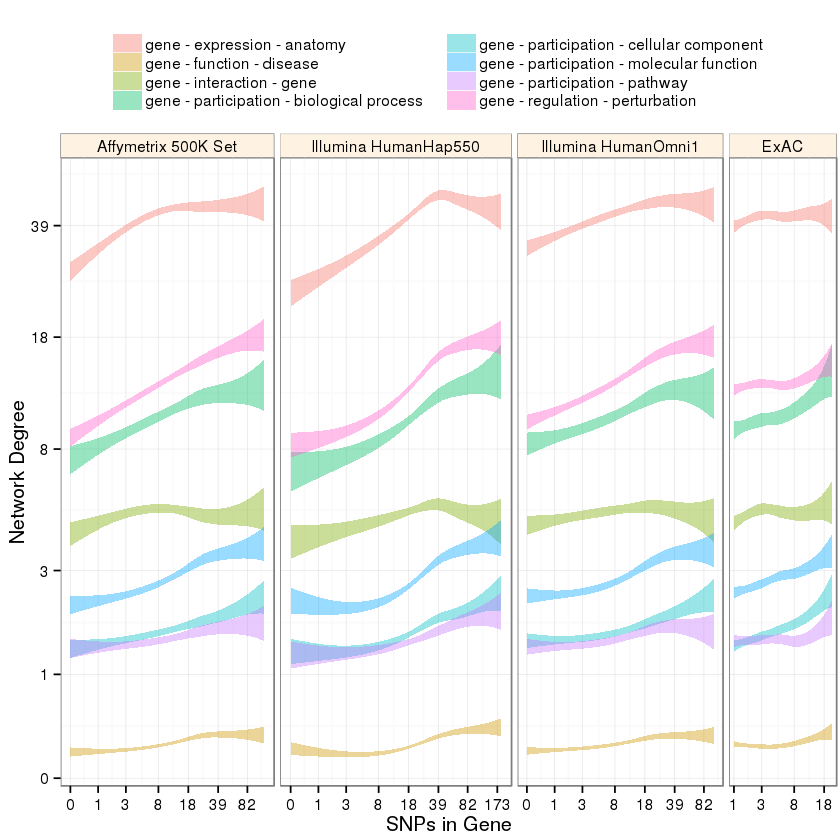

In [12]:
degree_labels = round(10 ** seq(0, 3, 0.32) - 1)
options(repr.plot.width=7, repr.plot.height = 7)
gg_0 = gathered_df %>%
  dplyr::filter(metaedge %in% metaedge_subset) %>%
  ggplot2::ggplot(aes(x=snps_log, y=degree_log, fill=metaedge)) %>% gg_base() +
  ggplot2::facet_grid(. ~ platform, space = 'free_x',  scales='free_x', labeller=facet_labeller) +
  ggplot2::geom_smooth(method='gam', formula=formula("y ~ s(x, bs='cs')"), linetype=0, n=1000, sp=50) +
  ggplot2::theme(legend.position='top', legend.direction='vertical',
                 legend.key=ggplot2::element_rect(color='white'),
                 legend.key.height = grid::unit(0.4, 'cm')) +
  ggplot2::scale_x_continuous(breaks=log10p(snp_labels), labels=snp_labels, name='SNPs in Gene') +
  ggplot2::scale_y_continuous(breaks=log10p(degree_labels), labels=degree_labels, name='Network Degree') +
  ggplot2::guides(fill = ggplot2::guide_legend(ncol = 2, title = NULL))

saveall(gg_0, 'degree-v-snps', w=7, h=7)
gg_0

## Network degree (as a percent of mean) versus SNPs in gene

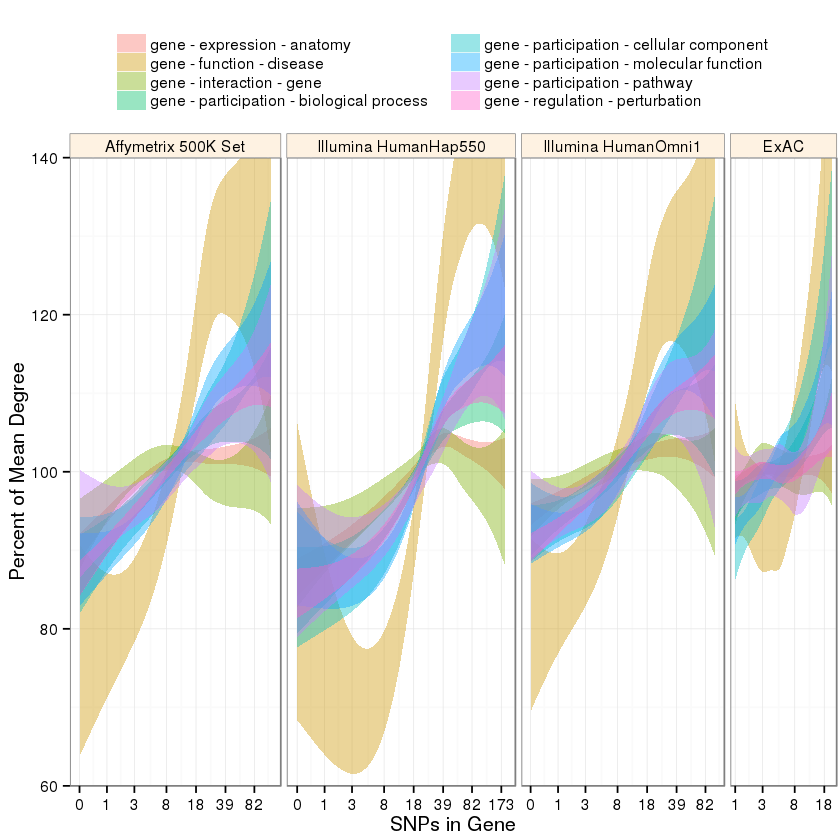

In [13]:
options(repr.plot.width=7, repr.plot.height = 7)
gg_1 = gathered_df %>%
  dplyr::group_by(metaedge) %>%
  dplyr::mutate(degree_percent = 100 * degree_log / mean(degree_log)) %>%
  dplyr::ungroup() %>%
  dplyr::filter(metaedge %in% metaedge_subset) %>%
  ggplot2::ggplot(aes(x=snps_log, y=degree_percent, fill=metaedge)) %>% gg_base() +
  ggplot2::facet_grid(. ~ platform, space = 'free_x',  scales='free_x', labeller=facet_labeller) +
  ggplot2::geom_smooth(method='gam', formula=formula("y ~ s(x, bs='cs')"), linetype=0, n=1000, sp=50) +
  ggplot2::coord_cartesian(ylim=c(60, 140)) +
  ggplot2::theme(legend.position='top', legend.direction='vertical',
                 legend.key=ggplot2::element_rect(color='white'),
                 legend.key.height = grid::unit(0.4, 'cm')) +
  ggplot2::scale_x_continuous(breaks=log10p(snp_labels), labels=snp_labels, name='SNPs in Gene') +
  ggplot2::ylab('Percent of Mean Degree') +
  ggplot2::guides(fill = ggplot2::guide_legend(ncol = 2, title = NULL))

saveall(gg_1, 'adj-degree-v-snps', w=7, h=7)
gg_1

## Network degree versus SNPs in Gene for all metaedges

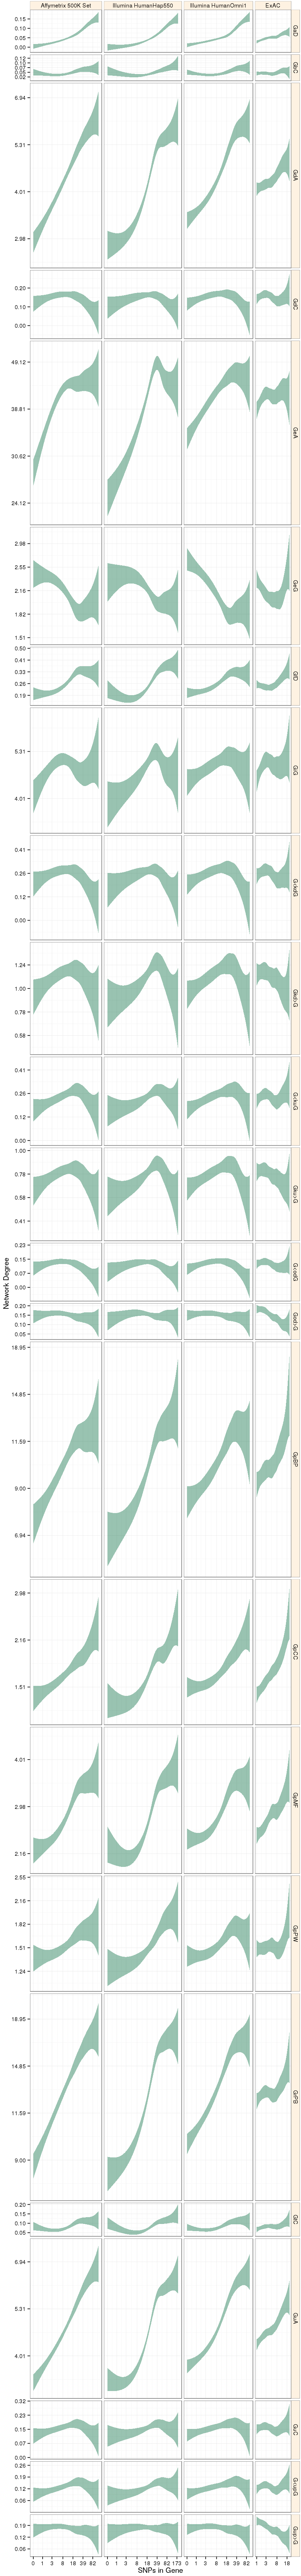

In [14]:
degree_labeler = function(x) {format(round(10 ** x - 1, 2), nsmall=2)}

degree_labels = round(10 ** seq(0, 3, 0.01) - 1, )
options(repr.plot.width=7, repr.plot.height = 60)
gg_2 = gathered_df %>%
  ggplot2::ggplot(aes(x=snps_log, y=degree_log)) %>% gg_base() +
  ggplot2::facet_grid(abbreviation ~ platform, scales='free', space='free', labeller=facet_labeller) +
  ggplot2::geom_smooth(method='gam', formula=formula("y ~ s(x, bs='cs')"), n=200, linetype=0, fill='#00693E', sp=15) +
  ggplot2::scale_x_continuous(breaks=log10p(snp_labels), labels=snp_labels, name='SNPs in Gene') +
  ggplot2::scale_y_continuous(labels=degree_labeler, name='Network Degree')

saveall(gg_2, 'degree-v-snps-all', w=7, h=60)
gg_2

In [15]:
# See metaedge abbreviations here
metaedge_df

Source: local data frame [24 x 7]

                                      metaedge abbreviation inverted  edges
1                    gene - binding - compound          GbC        1   2502
2               gene - upregulation - compound          GuC        1  17261
3         gene < knockdown upregulation < gene        G<kuG        1  78752
4    gene - participation - biological process         GpBP        0 534004
5                gene - upregulation - anatomy          GuA        0  97848
6                    gene - interaction - gene          GiG        0 297253
7  gene > overexpression downregulation > gene        God>G        0  14911
8    gene - participation - cellular component         GpCC        0  65377
9         gene > knockdown upregulation > gene        Gku>G        0  78752
10                    gene - target - compound          GtC        1   4603
..                                         ...          ...      ...    ...
Variables not shown: source_nodes (int), target_nodes (int), unbiased (int)